# 8. 딥러닝을 해킹하는 적대적 공격

## 8.0. 요약

### 8.0.1. 지난장

 지난 7장에서는 순차적 데이터를 input으로 하여 학습하는 순환신경망(Recurrent Neural Network, RNN)에 대해서 살펴보았다. RNN을 테스트해보기 위해서 IMDB Movie Dataset을 활용하여 영화 리뷰들을 활용한 감정분석과 Seq2Seq 기계학습에 대해서 예를 들었다. RNN은 앞서 6장까지의 정적인 데이터를 활용하는 신경망과 달리 시간이나 순서를 반영하여 학습을 수행하고 결과를 예측한다.

### 8.0.2 이번장

 이번 8장에서는 적대적 공격(Adversarial Attack)에 대해서 알아보려고 한다. 신경망 모델을 학습하는데는 오랜 시간이 소요될 수 있지만, 이를 속이는 행위는 데이터 셋의 임의의 포인트에 노이즈를 추가하는 등의 간단한 방법이 될 수 있다. 따라서, 어떻게 학습된 신경망을 기존의 의도와 다르게 노이즈를 주어 공격하는 적대적 공격에 대해서 알아보자.
 
## 8.1. 적대적 공격이란?

딥러닝 모델은 특정 사용자의 의도된 속임수에 의해 잘못된 예측을 수행할 수 있다. 하지만 앞서 간단히 말했듯이 딥러닝 모델을 속이는 방법은 그렇게 많은 노력과 복잡한 기술이 필요하지 않다. 이런 적대적 공격이 문제가 되는 이유는 비정상거래 탐지, 의료영상분석과 같은 실수가 용납되지 않는 상황에서 딥러닝 모델의 신뢰성이 의심받기 때문이다.

## 8.2. 적대적 공격의 종류

적대적 공격은 적절한 잡음을 통해 사람의 눈에는 똑같아보이지만 머신러닝 모델을 헷갈리게 하는 적대적 예제를 생성하는 것이 핵심이다. 적대적 공격에서는 일반 신경망에서 추구하는 최소의 오차가 아닌 이를 속이기 위해 오차를 극대화함으로써 잡음을 최적화하게 된다.

잡음을 생성하는 방법에는 여러가지가 있다.

1. 모델의 정보가 필요한가?
2. 원하는 정답으로 유도 가능한가?
3. 여러 모델을 동시에 헷갈리게 할 수 있는가?
4. 학습이 필요한가?

위의 네 가지 요인에 따라서 잡음 생성방법은 달라지게 된다.

### 1. 모델의 정보가 필요한가?

* 화이트박스방법: 기울기와 같은 모델 정보가 필요한지에  따라, 모델 정보를 토대로 잡음을 생성하는 방식
* 블랙박스방법: 모델의 정보 없이 생성하는 방법

### 2. 원하는 정답으로 유도 가능한가?

* 표적: 원하는 정답으로 유도할 수 있는 방식
* 비표적: 원하는 정답으로 유도할 수 없는 방식

### 3. 잡음을 생성하기 위해 반복된 학습(최적화)가 필요한가?

* 반복: 잡음 생성을 위해 반복된 학습이 필요한 방식
* 원샷: 잡음 생성을 위해 반복된 학습이 필요하지 않은 방식

### 4. 한 잡음이 특정 입력에만 적용되는가? or 모든 이미지에 적용될 수 있는가?

<br/>

### **결과적으로 가장 강력한 방법은,**

#### **모델 정보가 필요 없고, 원하는 정답으로 유도할 수 있으며, 복잡한 학습이 필요하지 않고, 여러 모델에 동시에 적용할 수 있는 방법이다.**


## 8.3. FGSM 공격

FGSM(Fast Gradient Sign Method)는 반복된 학습 없이 잡음을 생성하는 원샷 공격으로, 입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성한다. FGSM은 임의의 이미지의 가중치에 대해 특정 계수와 다른 이미지의 가중치를 더함으로써 대상모델의 신뢰도를 떨어뜨린느 방식이다.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

In [4]:
model = models.resnet101(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\kwon2/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth
100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:29<00:00, 6.09MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [7]:
img = Image.open('imagenet_samples/corgie.jpg')

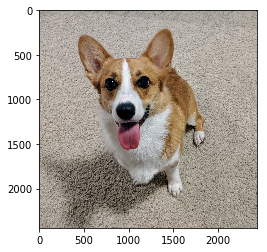

In [8]:
plt.imshow(img)

In [20]:
img_transforms = transforms.Compose([
    transforms.Resize((224,224), Image.BICUBIC),
    transforms.ToTensor()
]) 

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

img_tensor.shape

torch.Size([1, 3, 224, 224])

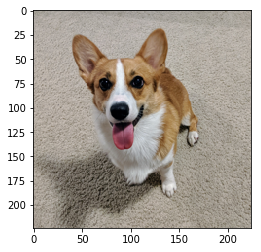

In [30]:
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()
plt.imshow(original_img_view)

In [41]:
output = model(img_tensor)
prediction = output.max(1,keepdim=False)[1].item()

prediction_idx = prediction
prediction_name = idx2class[prediction_idx]

print(f"Label Number: {prediction_idx}; Prediction Label Name: {prediction_name}")

Label Number: 263; Prediction Label Name: Pembroke, Pembroke Welsh corgi


In [38]:
output.max(1,keepdim=False)[1].item()

263

In [39]:
output.max(1,keepdim=False)

torch.return_types.max(
values=tensor([18.6775], grad_fn=<MaxBackward0>),
indices=tensor([263]))

In [42]:
def fgsm_attack(image, epsilon, gradient):
    sign_gradient = gradient.sign()
    preturbuted_image = image + epsilon * sign_gradient
    preturbuted_image = torch.clamp(preturbuted_image,0,1)
    return  preturbuted_image

In [45]:
img_tensor.requires_grad_(True)

output = model(img_tensor)

loss = F.nll_loss(output,torch.tensor([263]))
model.zero_grad()
loss.backward()

In [46]:
gradient = img_tensor.grad.data
epsilon = 0.03

preturbuted_data = fgsm_attack(img_tensor, epsilon, gradient)

In [50]:
output = model(preturbuted_data)
preturbuted_idx = output.max(1, keepdim=False)[1]
preturbuted_name = idx2class[preturbuted_idx]

print(f"Label Number: {preturbuted_idx}; Prediction Label Name: {preturbuted_name}")

Label Number: tensor([172]); Prediction Label Name: whippet


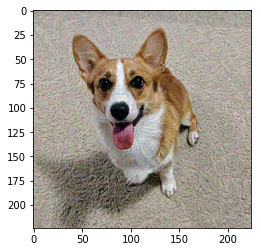

In [61]:
preturbuted_img = preturbuted_data.squeeze(0).detach().transpose(0,2).transpose(0,1).numpy()
plt.imshow(preturbuted_img)

Text(0.5,1,'whippet')

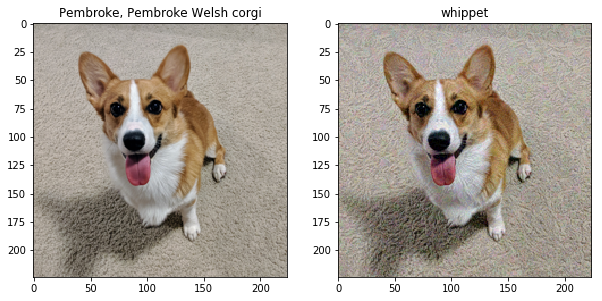

In [62]:
fig, axes = plt.subplots(1,2,figsize=[10,5])

axes[0].imshow(original_img_view)
axes[0].set_title(prediction_name)

axes[1].imshow(preturbuted_img)
axes[1].set_title(preturbuted_name)